In [22]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
dataset_name = "online_retail_sales"

In [24]:
#input_fname = "Online Retail.xlsx"
input_fname = "Online Retail.csv.gz"
output_dir = f'./../../processed/{dataset_name}/'
outp_fname = os.path.join(output_dir, f'{dataset_name}.csv')
outp_fig_fname = os.path.join(output_dir, f'{dataset_name}.png')

# Read Data

In [25]:
# data = pd.read_excel(input_fname)
# data.head()

data = pd.read_csv(input_fname, encoding="latin_1")

In [26]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [27]:
retail_data = data.copy()

In [28]:
retail_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


# Prepare Data

## Aggregate at the daily level 

In [29]:
# Update 'InvoiceDate' to keep only the date part
retail_data['InvoiceDate'] =pd.to_datetime(retail_data['InvoiceDate']).dt.date

# Create a new column called 'Sales' by multiplying 'Quantity' and 'UnitPrice'
retail_data['Sales'] = retail_data['Quantity'] * retail_data['UnitPrice']

# Group the data by 'InvoiceDate' and 'StockCode': sum Quantity and Sales
daily_retail_data = retail_data.groupby(['InvoiceDate', 'StockCode'])[['Quantity', 'Sales']].sum().reset_index()

# Show the first few rows of the grouped data
daily_retail_data.head()

,InvoiceDate,StockCode,Quantity,Sales
0,2010-12-01,10002,60,51.00
1,2010-12-01,10125,2,1.70
2,2010-12-01,10133,5,4.25
3,2010-12-01,10135,1,2.51
4,2010-12-01,11001,3,10.08


## Filter top 40 stock codes

In [30]:
# Find the top 40 StockCodes by total 'Sales'
top_stock_codes = retail_data.groupby('StockCode')['Sales'].sum().sort_values(ascending=False).head(40)
top_40_stock_codes = top_stock_codes.index.tolist()
# Display the top 40 StockCodes
print(top_40_stock_codes)

['DOT', '22423', '47566', '85123A', '85099B', '23084', 'POST', '22086', '84879', '79321', '22502', '22197', '23298', '22386', '23203', '21137', '22720', '23284', '22960', '82484', '20725', '22114', '22178', '22112', '85099F', '22910', '22469', '23245', '22727', '21931', '22470', '23199', '22355', '23355', '22411', '22457', '22699', '20685', '85099C', '22726']


In [31]:
# Filter the original retail_data to only contain the top 40 StockCodes
daily_retail_data = daily_retail_data[daily_retail_data['StockCode'].isin(top_40_stock_codes)]

# Show the first few rows to confirm the filtering
daily_retail_data.head()

,InvoiceDate,StockCode,Quantity,Sales
47,2010-12-01,20685,29,213.03
61,2010-12-01,20725,78,132.06
158,2010-12-01,21137,540,1830.60
423,2010-12-01,21931,54,107.56
470,2010-12-01,22086,274,891.10


## Fill all Missing Dates with Zeros

In [32]:
# Find the min and max dates in the filtered data
min_date = daily_retail_data['InvoiceDate'].min()
max_date = daily_retail_data['InvoiceDate'].max()

# Create a date range from min to max
date_range = pd.date_range(start=min_date, end=max_date)

# Aggregate the data by 'InvoiceDate' and 'StockCode' to ensure uniqueness
aggregated_data = daily_retail_data.groupby(['InvoiceDate', 'StockCode']).agg({'Quantity':'sum', 'Sales':'sum'}).reset_index()

# Create a new DataFrame with a complete date range for each StockCode
complete_data = (aggregated_data.set_index('InvoiceDate')
                 .groupby('StockCode')
                 .apply(lambda df: df.reindex(date_range))
                 .drop('StockCode', axis=1)
                 .reset_index()
                 .rename(columns={'level_1': 'InvoiceDate'}))

# Fill missing values with zero
complete_data.fillna(0, inplace=True)

# Check if all dates are present for each StockCode
complete_data.groupby('StockCode').apply(lambda df: df['InvoiceDate'].nunique() == len(date_range)).all()

True

In [33]:
complete_data.head()

,StockCode,InvoiceDate,Quantity,Sales
0,20685,2010-12-01,29.0,213.03
1,20685,2010-12-02,55.0,377.25
2,20685,2010-12-03,3.0,30.33
3,20685,2010-12-04,0.0,0.00
4,20685,2010-12-05,12.0,83.40


# Remove Series with Constant Values

- Stock code 23355 has zero volumes for most of the history. 
- Stock code 22502 has constant values near the end of the series. 

We will remove these two series.

In [34]:
complete_data = complete_data[~complete_data['StockCode'].isin(['22502', '23355'])]

In [35]:
complete_data.shape

(14212, 4)

In [36]:
series_col = "StockCode"
epoch_col = 'InvoiceDate'
epoch_label = "Date"
time_col = 'InvoiceDate'
value_col = 'Quantity'
exog_cols = ['Sales']

## Filter Data to end on 11/28/2011 

In [37]:
# Convert string to datetime
end_date = pd.to_datetime('2011-11-28')

# Filter the data to end on 2011-11-28
complete_data = complete_data[complete_data['InvoiceDate'] <= end_date]
complete_data.tail()

,StockCode,InvoiceDate,Quantity,Sales
14944,POST,2011-11-24,28.0,534.00
14945,POST,2011-11-25,15.0,456.40
14946,POST,2011-11-26,0.0,0.00
14947,POST,2011-11-27,0.0,0.00
14948,POST,2011-11-28,14.0,276.59


# Visualize Data

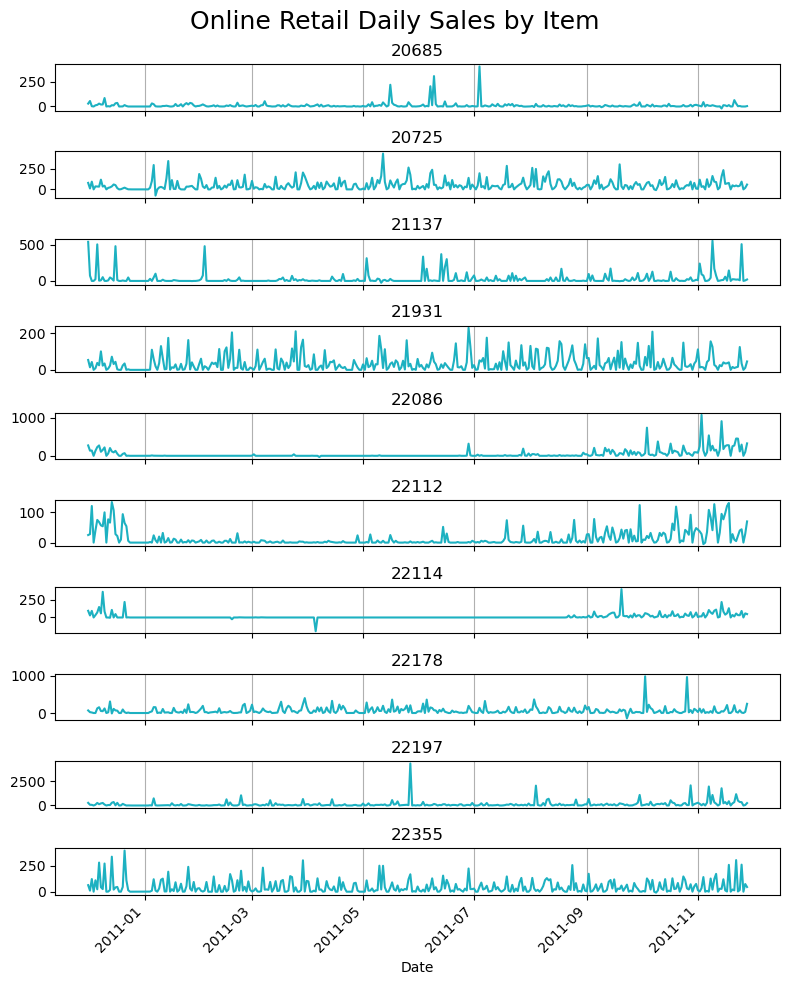

In [38]:
import matplotlib.pyplot as plt

def plot_series(df, series_col, val_col, epoch_col, epoch_label, num_series=10,
                filepath=outp_fig_fname, chart_title=dataset_name):
    """
    This function takes a dataframe and a number of series to chart.
    It creates a n x 1 subplot (with n being the number of series, at most 10) and plots those series.
    
    Parameters:
    df (DataFrame): dataframe.
    num_series (int): The number of series to plot, defaulted to 10.
    """
    
    # Get the unique series from the dataframe
    unique_series = df[series_col].unique()
    
    # Limit the number of series to plot
    series_to_plot = unique_series[:min(len(unique_series), num_series)]
    
    # Set up the subplots
    fig, axes = plt.subplots(nrows=min(num_series, len(series_to_plot)), ncols=1, figsize=(8, num_series*1))
    
    # If there's only one series to plot, axes will not be an array, so we wrap it in a list
    if num_series == 1:
        axes = [axes]
    
    # Define the color for the plots
    plot_color = '#1db1c1'
    
    # Plot each series on a separate subplot
    for i, (ax, series_id) in enumerate(zip(axes, series_to_plot)):
        # Filter the dataframe for the current series
        series_data = df[df[series_col] == series_id]
                
        # Plot the data
        ax.plot(series_data[epoch_col], series_data[val_col], color=plot_color)
        
        # Set the title and labels
        ax.set_title(series_id)
        # ax.set_ylabel('Trend')
        # Show x-axis grid
        ax.xaxis.grid(True)
        
        # Show x-axis labels only for the last (bottom) plot
        if i < len(series_to_plot) - 1:
            ax.set_xticklabels([])
        else:
            # Rotate date labels to avoid overlap
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
            ax.set_xlabel(epoch_label)            
        
        # Rotate date labels to avoid overlap
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.suptitle(chart_title, fontsize=18)
    # Adjust layout to prevent overlap
    plt.tight_layout()
    # Save figure
    plt.savefig(filepath)
    
    plt.show()

# Plot a few series
plot_series(
    complete_data,
    series_col=series_col,
    val_col=value_col,
    epoch_col=time_col,
    epoch_label=epoch_label,
    num_series=10,
    filepath=outp_fig_fname,
    chart_title="Online Retail Daily Sales by Item"
)  


# Save Main Data File

In [39]:
if time_col: 
    all_cols = [series_col, time_col, value_col] + exog_cols
else: 
    all_cols = [series_col, value_col] + exog_cols
complete_data.sort_values(by=[series_col, epoch_col], inplace=True)
complete_data[all_cols].to_csv(outp_fname, index=False, float_format="%.2f")